(1055, 50, 1)
(1, 50, 1)
Train on 7381 samples, validate on 2109 samples
Epoch 1/1000
7381/7381 [==============================] - 5s 704us/sample - loss: 0.0178 - last_time_step_mse: 0.0167 - val_loss: 0.0068 - val_last_time_step_mse: 0.0068
Epoch 2/1000
7381/7381 [==============================] - 4s 603us/sample - loss: 0.0066 - last_time_step_mse: 0.0066 - val_loss: 0.0065 - val_last_time_step_mse: 0.0065
Epoch 3/1000
7381/7381 [==============================] - 4s 589us/sample - loss: 0.0065 - last_time_step_mse: 0.0064 - val_loss: 0.0063 - val_last_time_step_mse: 0.0064
Epoch 4/1000
7381/7381 [==============================] - 4s 602us/sample - loss: 0.0064 - last_time_step_mse: 0.0064 - val_loss: 0.0063 - val_last_time_step_mse: 0.0063
Epoch 5/1000
7381/7381 [==============================] - 5s 622us/sample - loss: 0.0063 - last_time_step_mse: 0.0063 - val_loss: 0.0064 - val_last_time_step_mse: 0.0064
Epoch 6/1000
7381/7381 [==============================] - 4s 598us/sample - l

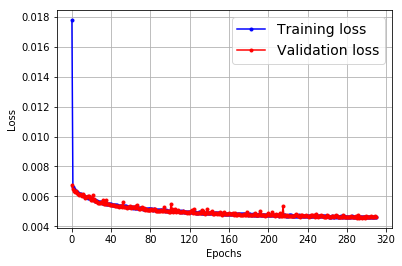

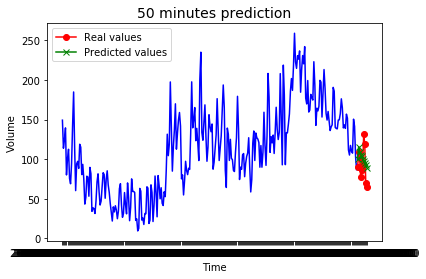

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import sklearn
import sys
import io

def plot_learning_curves(loss, val_loss):
    plt.figure()
    plt.plot(np.arange(len(loss)), loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)), val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

n_steps = 50
forecast = 10

#EXTRACT FLOW, Z SCORE, OUTLIERS
data_west = pd.read_csv('denoised_data_1016_west.csv')
data_west_o = np.array(data_west.FLOW)

#EXRTEND DATA
array_to_concatinate = data_west_o[288:]
for iter in range (35):
    data_west_o = np.concatenate([data_west_o,array_to_concatinate])

#SCALE AND RESHAPE DATA
scaler = MinMaxScaler()
array = data_west_o.reshape(-1, 1)
array_scaled = scaler.fit_transform(array)

flow_reshaped = array_scaled[:(len(array_scaled) - (len(array_scaled) % (n_steps+forecast)))].reshape(-1, (n_steps+forecast), 1)
#TRAIN SET, VALIDATION SET, TEST SET
test = int(0.7 * flow_reshaped.shape[0])
valid = int(0.9 * flow_reshaped.shape[0])

X_train = flow_reshaped[:test, :n_steps]
X_valid = flow_reshaped[test:valid, :n_steps]
X_test = flow_reshaped[valid:, :n_steps]
print(X_test.shape)
print(X_test[-1:].shape)

#prepare targets
Y = np.empty((flow_reshaped.shape[0], n_steps, forecast))
for step_ahead in range(1, forecast + 1):
    Y[:, :, step_ahead - 1] = flow_reshaped[:, step_ahead:step_ahead + n_steps, 0]

y_train = Y[:test]
y_valid = Y[test:valid]
y_test = Y[valid:]

#MODEL
def last_time_step_mse(Y_true, Y_pred):
     return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=1000,
                    validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

model.save("vawenet_1016_west.h5")
plot_learning_curves(history.history["loss"], history.history["val_loss"])

#50 MIN FORECAST
#50 MIN FORECAST
#flow
flow_unscaled = array[:(len(array) - (len(array) % (n_steps + forecast)))].reshape(-1, (n_steps + forecast), 1)
y_test_unscaled = flow_unscaled[valid:, n_steps:, 0]
y_real_rescaled = y_test_unscaled[-1, :].reshape(-1, 1)
print(y_real_rescaled.shape)

flow_not_reshaped = array[:(len(array) - (len(array) % (n_steps+forecast)))]

#flow prediction
y_pred = model.predict(X_test[-1, :].reshape(-1, n_steps, 1)) #shape (1, 50, 10)
y_pred = y_pred[-1,-1,:].reshape(-1,1)
y_pred_rescaled = scaler.inverse_transform(y_pred).reshape(-1, 1) #shape (10, 1)
print(y_pred_rescaled.shape)

#time
time_not_reshaped = np.array(data_west['TIME'][:(len(data_west['TIME']) - (len(data_west['TIME']) % (n_steps+forecast)))])
time_reshaped = np.array(data_west['TIME'][:(len(data_west['TIME']) - (len(data_west['TIME']) % (n_steps+forecast)))]).\
    reshape(-1, (n_steps+forecast), 1)

valid_time = int(0.9 * time_reshaped.shape[0])
y_time_test = time_reshaped[valid_time:, n_steps:, 0]
print(y_time_test[-1, :].shape)

def plot_prediction(y_real_resacled, y_pred_rescaled, flow_not_reshaped, time_not_reshaped, y_time_test):
    plt.figure()
    plt.title("50 minutes prediction", fontsize=14)
    plt.plot(time_not_reshaped[-300:-forecast], flow_not_reshaped[-300:-forecast], 'b-')
    plt.plot(y_time_test[-1, :], y_real_resacled, 'ro-', label = 'Real values')
    plt.plot(y_time_test[-1, :], y_pred_rescaled, 'gx-', label = 'Predicted values')
    plt.legend(loc="upper left")
    plt.xlabel("Time")
    plt.ylabel('Volume')

plot_prediction(y_real_rescaled, y_pred_rescaled, flow_not_reshaped, time_not_reshaped, y_time_test)

plt.show()